# Cluster-II workflow

This notebook presents a computational workflow to detect trees from aerial imagery with a train/test split of image tiles based on a two-level *k*-means clustering of image descriptors. The first level *k*-means divides the dataset into 4 clusters of image tiles. Within each cluster, the second level *k*-means is used to select the image tiles for training in a way that enhances the variety of scenes represented in the training tiles. The selected tiles will be used to train a **separate classifier** dedicated to the tiles in such first level cluster.

In order to avoid issues with relative paths, let us first of all change the working directory to the repository's root

In [1]:
%cd ..

/home/martibosch/data-science/detectree-example


In [2]:
import os
from os import path

import detectree as dtr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio import plot

from src import make_confusion_df, make_response_tiles 

figwidth, figheight = plt.rcParams['figure.figsize']
%matplotlib inline

Let us now use the Makefile at the root of this repository ensure that we have the required data input data - i.e., the tiles from [Zurich's RGB orthophoto of summer 2014/15](https://www.geolion.zh.ch/geodatensatz/2831) that lie within Zurich's municipal boundaries - has been downloaded (see [the background notebook](https://github.com/martibosch/detectree-example/blob/master/notebooks/background.ipynb) for more details).

In [3]:
!make tiles

make: Nothing to be done for 'tiles'.


## Train/test split

In order to select which image tiles are to be used to train the classifier, we will follow the 'Cluster-I' method described in Yang et al. [1], which consists of the following steps (see [the background notebook](https://github.com/martibosch/detectree-example/blob/master/notebooks/background.ipynb) for more details on the procedure):

1. Compute image descriptors [2] for each tile of the dataset
2. Apply *k*-means to the image descriptors to divide the dataset into 4 first-level clusters
3. Within each first-level cluster, apply a second-level *k*-means to the image descriptors with the number of clusters that corresponds to the number of tiles that are to be used to train the classifier, i.e., in a first-level cluster of 400 tiles and a desired 1% of training tiles, the number of second-level clusters would be set to 4.
4. Within each first-level cluster, select the tiles that are closest to each cluster's centroid to train **a separate classifier** dedicated to the tiles in such first-level cluster.

In detectree, the above procedure is done with the `train_test_split` method of the `TrainingSelector` class. Note that the initialization of `TrainingSelector` accepts a set of keyword arguments to customize how the image descriptors are computed (see [its documentation](https://detectree.readthedocs.io/en/latest/train_test_split.html#detectree.TrainingSelector.__init__) for more details).

In [4]:
ts = dtr.TrainingSelector(img_dir='data/interim/tiles')

In order to reduce the computational cost of the *k*-means clustering, Principal Component Analysis (PCA) is be used to reduce the dimensionality of the image descriptors, e.g., to 24 components. This is specified in the `num_components` keyword argument of the `train_test_split` method.

After the instantiation of a `TrainingSelector`, its `train_test_split` method can be used as follows (the processing can take a while since it involves the computation of the image descriptor for each tile):

In [5]:
split_df, evr = ts.train_test_split(method='cluster-II',
                                    num_components=24,
                                    return_evr=True)

[########################################] | 100% Completed |  3min 18.6s


The `train_test_split` method returns a pandas data frame with the train test split. Additionally, if `return_evr` is `True`, `train_test_split` also returns the variance ratio explained by the PCA, which in this case is:

In [6]:
evr

0.9288608997781252

The data frame of the train/test split looks as follows:

In [7]:
split_df.head()

,img_filepath,img_cluster,train
0,data/interim/tiles/1091-144_06.tif,0,True
1,data/interim/tiles/1091-233_07.tif,2,False
2,data/interim/tiles/1091-232_02.tif,3,False
3,data/interim/tiles/1091-124_05.tif,1,False
4,data/interim/tiles/1091-234_23.tif,3,False


The `img_cluster` column features the label of the first-level clustering. The tiles to be used to train each cluster's classifier are the following ones:

In [8]:
split_df[split_df['train']]

,img_filepath,img_cluster,train
0,data/interim/tiles/1091-144_06.tif,0,True
30,data/interim/tiles/1091-213_05.tif,1,True
117,data/interim/tiles/1091-231_07.tif,3,True
134,data/interim/tiles/1091-322_11.tif,2,True


Note that since our dataset is relatively small (225 tiles) and we are only selecting 1% of the tiles for training, only 1 tile has been selected for training in each of the 4 first-level clusters.

## Interlude: computing the responses from LIDAR data

Since detectree uses a supervised learning approach, we need to manually provide the responses (i.e., binary images representing the ground-truth tree/non-tree masks) for the training tiles so that the tree/non-tree pixel classifier can be trained. 

There are many ways to obtain such masks, the most straight-forward being manual edition in a raster graphics editor software such as [GIMP](https://www.gimp.org/). In the case of this example dataset, the ground-truth masks can be extracted from [Zurich's 2014 LIDAR dataset](https://www.geolion.zh.ch/geodatensatz/show?gdsid=343). Such task is accomplished in the two cells below, whose content is out of the scope of detectree.

In [9]:
!make download_lidar_shp

make: Nothing to be done for 'download_lidar_shp'.


In [10]:
lidar_gdf = gpd.read_file('data/raw/lidar/lidar2014.shp')
# lidar_gdf.iloc[:20].plot(edgecolor=(0,0,0))

response_dir = 'data/interim/cluster-II_responses'
if not path.exists(response_dir):
    os.mkdir(response_dir)

make_response_tiles.make_response_tiles(split_df, lidar_gdf, 'data/raw/lidar',
                                        response_dir)

['data/interim/cluster-II_responses/1091-144_06.tif',
 'data/interim/cluster-II_responses/1091-213_05.tif',
 'data/interim/cluster-II_responses/1091-231_07.tif',
 'data/interim/cluster-II_responses/1091-322_11.tif']

Let us now plot side by side the training tiles (left) and the LIDAR-based ground-truth masks.

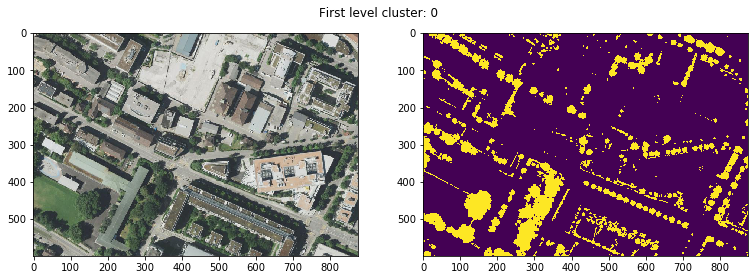

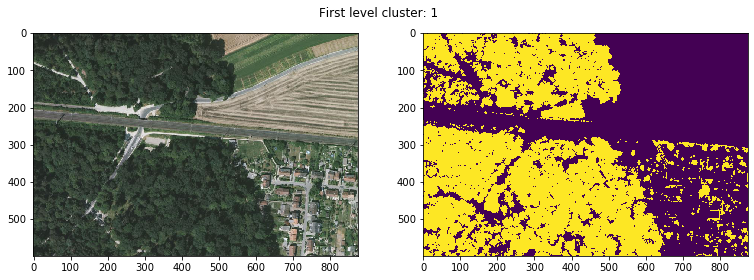

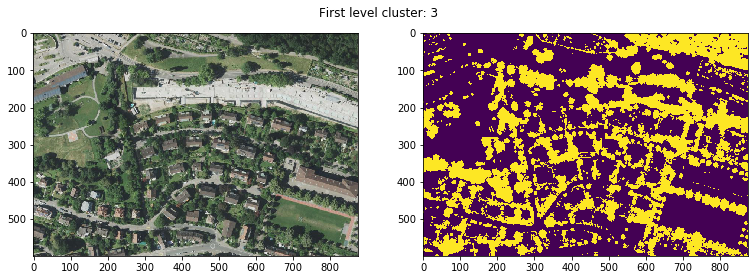

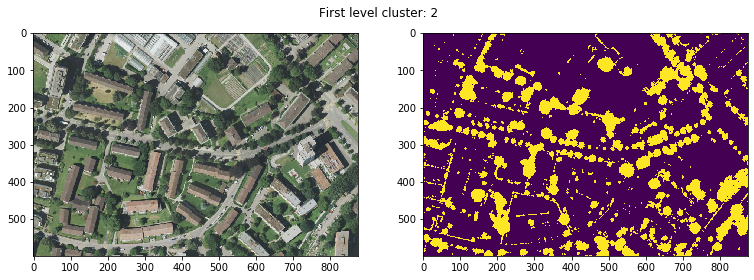

In [11]:
train_df = split_df[split_df['train']]
for img_filepath, img_cluster in zip(train_df['img_filepath'],
                                     train_df['img_cluster']):
    fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
    fig.suptitle(f"First level cluster: {img_cluster}", y=.9)
    with rio.open(img_filepath) as src:
        plot.show(src.read(), ax=axes[0])
    with rio.open(path.join(response_dir, path.basename(img_filepath))) as src:
        plot.show(src.read(), ax=axes[1])

Note that accuracy of the ground-truth masks is crucial to train a good classifier.

## Training the classifiers (note the final "s")

We can now proceed to the training of the classifier. In detectree, this can be done with the `train_classifiers` (not to be confused with `train_classifier`, note the final "s") method of the `ClassifierTrainer` class, which takes two positional arguments: the train/test split data frame and the directory of the response images (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.ClassifierTrainer.train_classifiers) for more details). The training of the classifier can be customized by providing a set of keyword arguments to the initialization of `ClassifierTrainer` (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.ClassifierTrainer.__init__) for more details). Note that the training of the classifier can take some time.

In [12]:
clf_dict = dtr.ClassifierTrainer().train_classifiers(split_df, response_dir)

[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  9min 53.6s


The returned object is a dictionary mapping the label of the first-level cluster to its trained [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) instance.

In [13]:
clf_dict

{0: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=200, random_state=None),
 1: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=200, random_state=None),
 2: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=200, random_state=None),
 3: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=200, random_state=None)}

## Predicting tree/non-tree labels

The dictionary of trained classifiers can be used to predict the tree/non-tree labels from any given image of the dataset. To that end, detectree provides the `Classifier` class, which features a `classify_img` method that can be (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.Classifier.classify_img) for more details).

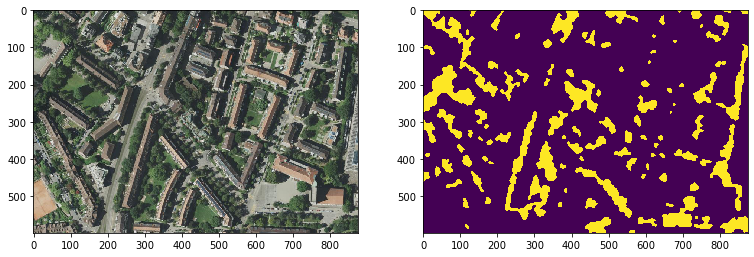

In [14]:
test_filepath, img_cluster = split_df[~split_df['train']][[
    'img_filepath', 'img_cluster'
]].sample(1).iloc[0]

c = dtr.Classifier()

y = c.classify_img(test_filepath, clf_dict[img_cluster])

fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
with rio.open(test_filepath) as src:
    plot.show(src.read(), ax=axes[0])
axes[1].imshow(y)

Note that the second argument of `classify_img`, namely the classifier, requires that for each tile, we select its respective classifier from `clf_dict`. If multiple tiles are to be classified, it might be more appropriate to use the `classify_imgs` method, which operates directly on the train/test split data frame and the dictionary of classifiers `clf_dict` (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.Classifier.classify_imgs) for more details), and uses dask to classify the tiles in parallel.

In [15]:
output_dir = 'data/interim/cluster-II_pred-tiles'
if not path.exists(output_dir):
    os.mkdir(output_dir)

sample_df = split_df.sample(20)
pred_tiles = c.classify_imgs(sample_df, output_dir, clf_dict=clf_dict)

[########################################] | 100% Completed | 19.0s
[########################################] | 100% Completed | 52.9s
[########################################] | 100% Completed | 28.9s


The returned `pred_tiles` is a dictionary mapping each first-level cluster to its respective list of paths predicted tiles.

In [16]:
pred_tiles

{0: ['data/interim/cluster-II_pred-tiles/1091-124_01.tif',
  'data/interim/cluster-II_pred-tiles/1091-322_18.tif',
  'data/interim/cluster-II_pred-tiles/1091-232_11.tif'],
 2: ['data/interim/cluster-II_pred-tiles/1091-213_22.tif',
  'data/interim/cluster-II_pred-tiles/1091-231_11.tif',
  'data/interim/cluster-II_pred-tiles/1091-213_16.tif',
  'data/interim/cluster-II_pred-tiles/1091-234_17.tif',
  'data/interim/cluster-II_pred-tiles/1091-322_05.tif',
  'data/interim/cluster-II_pred-tiles/1091-142_20.tif',
  'data/interim/cluster-II_pred-tiles/1091-322_13.tif',
  'data/interim/cluster-II_pred-tiles/1091-234_14.tif',
  'data/interim/cluster-II_pred-tiles/1091-144_02.tif',
  'data/interim/cluster-II_pred-tiles/1091-233_07.tif',
  'data/interim/cluster-II_pred-tiles/1091-322_15.tif'],
 3: ['data/interim/cluster-II_pred-tiles/1091-233_10.tif',
  'data/interim/cluster-II_pred-tiles/1091-231_03.tif',
  'data/interim/cluster-II_pred-tiles/1091-124_24.tif',
  'data/interim/cluster-II_pred-tiles

## Validation
    
In order to evaluate the accuracy of the classifier, we can use the code below to build a confusion matrix, which uses the LIDAR dataset to compute the ground-truth masks. The `frac` keyword argument sets the fraction of tiles that will be randomly-sampled and used for validation.

In [17]:
confusion_df = make_confusion_df.make_confusion_df(lidar_gdf,
                                                   'data/raw/lidar',
                                                   split_df=split_df,
                                                   frac=.05,
                                                   clf_dict=clf_dict)
confusion_df

[########################################] | 100% Completed | 25min 18.1s


predicted,0,255
actual,,
0,0.501041,0.063266
255,0.076925,0.358768


The trace of the confusion matrix corresponds to the accuracy of the classifier:

In [18]:
accuracy = np.trace(confusion_df)
accuracy

0.8598084848484848

## References

1. Yang, L., Wu, X., Praun, E., & Ma, X. (2009). Tree detection from aerial imagery. In Proceedings of the 17th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (pp. 131-137). ACM.

2. Oliva, A., & Torralba, A. (2001). Modeling the shape of the scene: A holistic representation of the spatial envelope. International journal of computer vision, 42(3), 145-175.